In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import colormaps

In [2]:
def simulate(P_r, P_s, P_p, nr_init, ns_init, np_init, steps=100):
    n_r = np.zeros(steps)
    n_s = np.zeros(steps)
    n_p = np.zeros(steps)

    n_r[0] = nr_init
    n_s[0] = ns_init
    n_p[0] = np_init

    for t in range(0, steps-1):
        n_r[t+1] = n_r[t] + n_r[t]*(n_s[t]*P_r - n_p[t]*P_p)
        n_s[t+1] = n_s[t] + n_s[t]*(n_p[t]*P_s - n_r[t]*P_r)
        n_p[t+1] = n_p[t] + n_p[t]*(n_r[t]*P_p - n_s[t]*P_s)
    
    return pd.DataFrame({'$n_r$': n_r, '$n_s$': n_s, '$n_p$': n_p})

<Axes: >

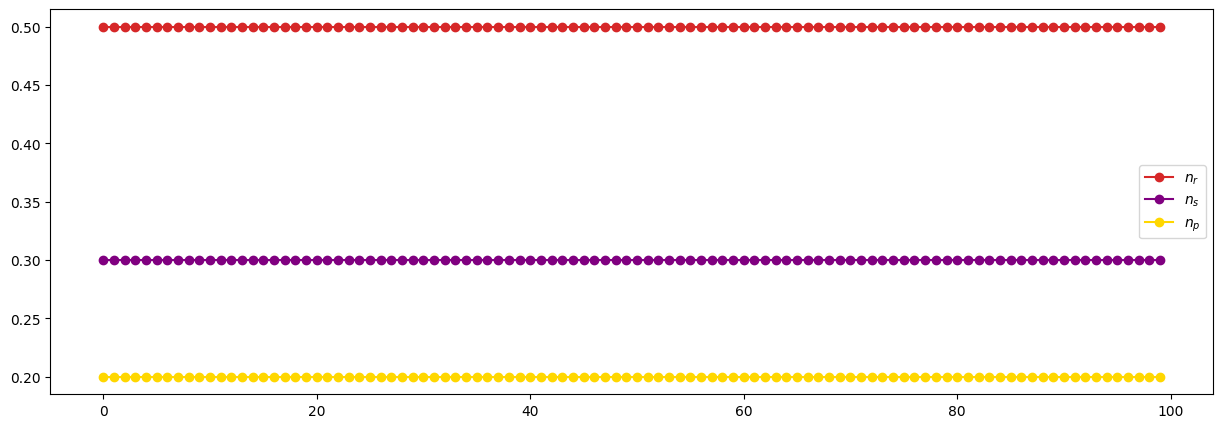

In [3]:
# equilibrium
fig, ax = plt.subplots(1, figsize=(15, 5))
results_df = simulate (P_r=0.2, P_s=0.5, P_p=0.3, nr_init=0.5, ns_init=0.3, np_init=0.2, steps=100)
results_df.plot(style='o-', ax=ax, color=['tab:red', 'purple', 'gold'])

<Axes: >

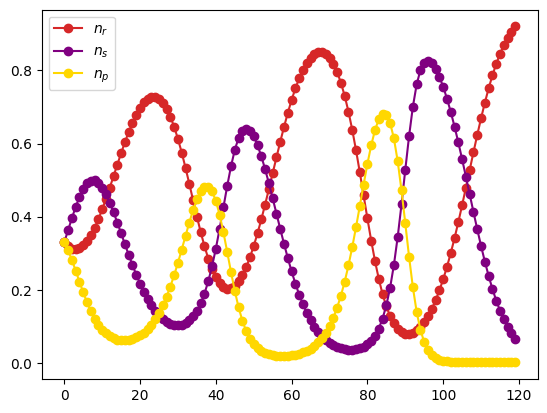

In [4]:
results_df = simulate (P_r=0.2, P_s=0.5, P_p=0.3, nr_init=0.33, ns_init=0.33, np_init=0.33, steps=120)
results_df.plot(style='-o', color=['tab:red', 'purple', 'gold'])

In [5]:
results_df.min()

$n_r$    0.079378
$n_s$    0.035906
$n_p$    0.000967
dtype: float64

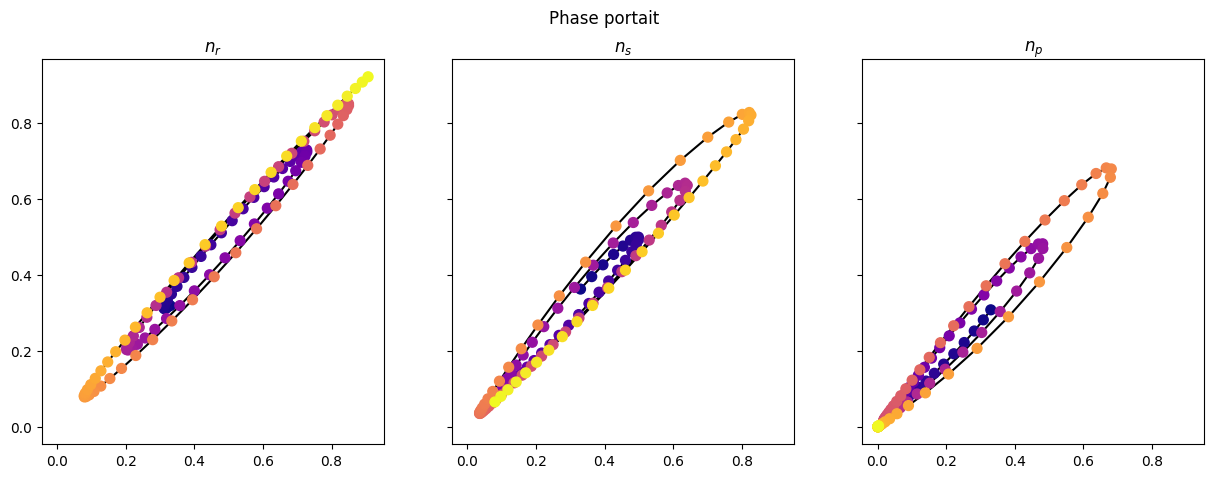

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)
cmap = colormaps['plasma']
colors = cmap(np.linspace(0, 1, (results_df['$n_r$'].shape[0]-1))) 
axs[0].plot(results_df['$n_r$'][0:-1], results_df['$n_r$'][1:], '-', color='k', zorder=1)
axs[0].scatter(results_df['$n_r$'][0:-1], results_df['$n_r$'][1:], c=colors, s=50, zorder=2)
axs[0].set_title('$n_r$')
axs[1].plot(results_df['$n_s$'][0:-1], results_df['$n_s$'][1:], '-', label='$n_s$', color='k', zorder=1)
axs[1].scatter(results_df['$n_s$'][0:-1], results_df['$n_s$'][1:], c=colors, s=50, zorder=2)
axs[1].set_title('$n_s$')
axs[2].plot(results_df['$n_p$'][0:-1], results_df['$n_p$'][1:], '-', color='k', zorder=1)
axs[2].scatter(results_df['$n_p$'][0:-1], results_df['$n_p$'][1:], c=colors, s=50, zorder=2) 
axs[2].set_title('$n_p$')
fig.suptitle("Phase portait");
# NOTE: actual phase portait is 4D

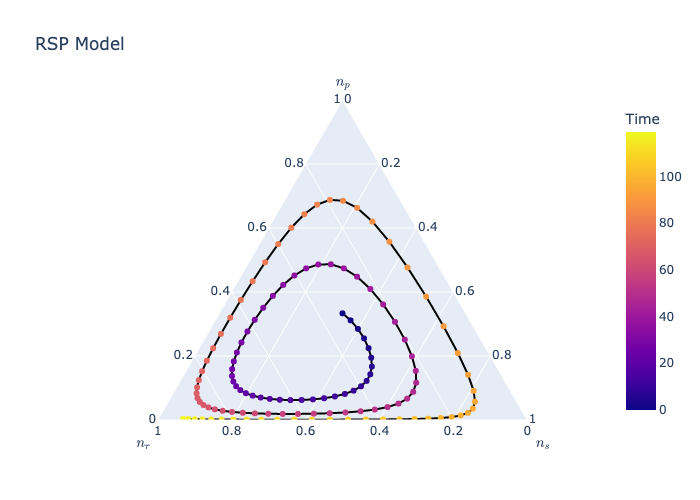

In [7]:
fig = px.scatter_ternary(
    results_df,
    a="$n_p$",
    b="$n_r$",
    c="$n_s$",
    color=results_df.index,
    size_max=10,
    title="RSP Model"
    )
fig.update_traces(mode='lines+markers', line=dict(color='black'))
fig.update_layout(coloraxis_colorbar=dict(title='Time'))
fig.show('png')

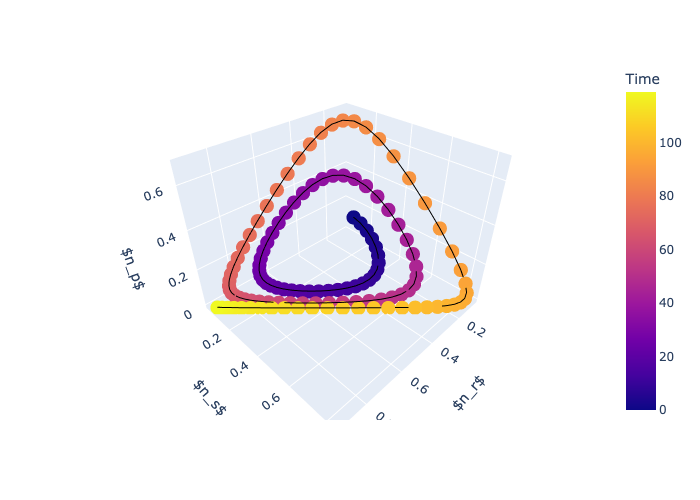

In [8]:
fig = px.scatter_3d(results_df, x='$n_r$', y='$n_s$', z='$n_p$', color=results_df.index)
fig.update_traces(mode='lines+markers', line=dict(color='black'))
fig.update_layout(coloraxis_colorbar=dict(title='Time'))
fig.show()
fig.show('png')

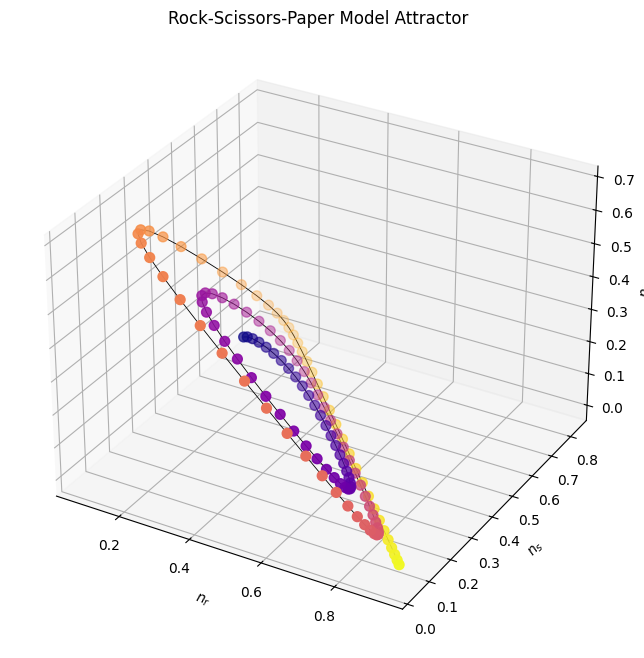

In [9]:
xyzs = np.array(results_df)
ax = plt.figure(figsize=(12, 8)).add_subplot(projection='3d')
ax.plot(*xyzs.T, 'k', lw=0.6)
colors = cmap(np.linspace(0, 1, (results_df['$n_r$'].shape[0]))) 
ax.scatter(*xyzs.T, c=colors, s=50, zorder=2)
ax.set_xlabel("$n_r$")
ax.set_ylabel("$n_s$")
ax.set_zlabel("$n_p$")
ax.set_title("Rock-Scissors-Paper Model Attractor")
plt.show()

In [10]:
R, S = np.mgrid[0:1:10j, 0:1:10j]
R, S = R.ravel(), S.ravel()
mask = R + S <= 1
R, S = R[mask], S[mask]
P = 1 - R - S

Pr=0.2
Ps=0.5
Pp=0.3

u = R*(S*Pr - P*Pp)
v = S*(P*Ps - R*Pr)
w = P*(R*Pp - S*Ps)

results_df = simulate (P_r=0.2, P_s=0.5, P_p=0.3, nr_init=0.33, ns_init=0.33, np_init=0.33, steps=120)

In [11]:
fig = go.Figure(data = go.Cone(
    x=R,
    y=S,
    z=P,
    u=u,
    v=v,
    w=w,
    sizemode="absolute",
    sizeref=0.2))
fig.add_trace(go.Scatter3d(
    x=results_df['$n_r$'], y=results_df['$n_s$'], z=results_df['$n_p$'],
    line=dict(color='black'),
    marker=dict(
        size=2,
        color=results_df.index,
        opacity=0.8,
    )
))
fig.show('png')